In [50]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.compose import make_column_selector as selector
from sklearn import set_config

from src.nnet import ClassifierModule
from src.ordinal import OrdinalEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CyclicLR

In [51]:
def emb_sz_rule(n_cat): return min(600, round(1.6 * n_cat**0.56))
def emb_sz_rule2(n_cat): return min(50, (n_cat + 1) // 2)

In [52]:
set_config(display='diagram')

In [53]:
path = Path('..', 'data', 'raw')
credit = pd.read_csv(path / 'credit_data.csv').rename(columns=str.lower)
cat_names = ['home', 'marital', 'records', 'job']
credit[cat_names] = credit[cat_names].astype('str')

dep_var = ['status']
cat_names = ['home', 'marital', 'records', 'job']
cnt_names = ['seniority', 'time', 'age', 'expenses', 'income', 'debt', 'amount', 'price', 'assets']

In [54]:
def ordinal(X, cols): 
    X_encoded = X.copy(deep=True)

    for col in cols:
        X_encoded.loc[:, col] = LabelEncoder().fit_transform(X_encoded.loc[:, col])
    return X_encoded

In [55]:
credit = ordinal(credit, cols=cat_names + dep_var)

In [56]:
cat_dims = [int(credit[col].nunique()) for col in cat_names]
emb_szs = [(x, emb_sz_rule(x)) for x in cat_dims]

In [57]:
n = len(credit)
valid_idx = np.random.choice(range(n), np.ceil(n * 0.2).astype('int'))
train_idx = [i for i in range(n) if i not in valid_idx]
X_train, y_train = credit.loc[train_idx, credit.columns != 'status'], credit.loc[train_idx, 'status']
X_test, y_test = credit.loc[valid_idx, credit.columns != 'status'], credit.loc[valid_idx, 'status']

In [127]:
net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=5,
    optimizer=optim.SGD,
    criterion=nn.CrossEntropyLoss,
    callbacks=[('lr_scheduler', LRScheduler(policy=CyclicLR, base_lr=0.01, max_lr=0.05))],
    module__emb_szs=emb_szs, 
    module__cont=[0, 2, 3, 7, 8, 9, 10, 11, 12], 
    module__categ=[1, 4, 5, 6], 
    module__out_sz=2, 
    device='cuda'  # uncomment this to train with CUDA
)

In [128]:
imputer = Pipeline([
    ('impute', KNNImputer(add_indicator=True))
])

scaler = Pipeline([
    ('scale', StandardScaler()),
])

col_transform = ColumnTransformer([
    ('number', imputer, selector(dtype_include=np.number)),
    ('float', scaler, selector(dtype_include=float))
])

clf = Pipeline([
    ('preproc', col_transform),
    ('net', net)
])

In [129]:
clf = clf.fit(X_train, y_train)

TypeError: __init__() missing 1 required positional argument: 'layers'

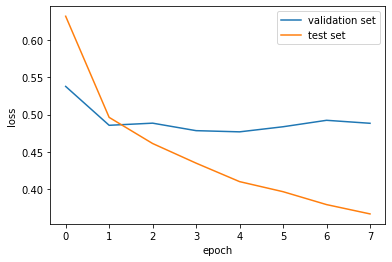

In [87]:
import matplotlib.pyplot as plt
plt.plot(clf.named_steps['net'].history[:, 'valid_loss'], label='validation set')
plt.plot(clf.named_steps['net'].history[:, 'train_loss'], label='test set')
#plt.vlines(x=np.argmax(clf.named_steps['net'].history[:, 'valid_acc']), ymin=.3, ymax=0.55, linestyle='dashed', colors='red')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend();

In [156]:
params = {
    'net__callbacks__lr_scheduler__base_lr': [.01, .05, .1],
    'net__callbacks__lr_scheduler__max_lr': [.1, .2],
    'net__module__layers': [[512, 256, 128], [1024, 512, 256, 128]],
    'net__module__emb_drop': [0, .05, .1],
    'net__module__emb_szs': [[(7, 5), (6, 4), (2, 2), (5, 4)], [(7, 6), (6, 5), (2, 3), (5, 5)]]
}

gs = RandomizedSearchCV(clf, params, refit=False, cv=3, n_iter=50)
gs = gs.fit(X_train, y_train)

ss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6337       0.7181        0.5692  0.1061
      2        0.4948       0.7510        0.5214  0.1111
      3        0.4334       0.7613        0.5046  0.1107
      4        0.3753       0.7593        0.5528  0.1122
      5        0.3227       0.7737        0.5965  0.1091
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6261       0.7346        0.5312  0.1093
      2        0.5426       0.7469        0.5343  0.1384
      3        0.5171       0.7366        0.5756  0.1096
      4        0.4695       0.7819        0.4910  0.1112
      5        0.4281       0.7695        0.4850  0.1125
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6328       0.7222        0.5406  0.1086
      2        0.5679       0.7798        0.5310  

In [157]:
print(gs.best_score_, gs.best_params_)

0.769695572685383 {'net__module__layers': [512, 256, 128], 'net__module__emb_szs': [(7, 5), (6, 4), (2, 2), (5, 4)], 'net__module__emb_drop': 0, 'net__callbacks__lr_scheduler__max_lr': 0.05, 'net__callbacks__lr_scheduler__base_lr': 0.05}


In [151]:
emb_szs

[(7, 5), (6, 4), (2, 2), (5, 4)]

In [124]:
import re
[i for i in clf.get_params().keys() if re.match('.**', i)]

[]

In [ ]:
0.7740878592913495 {'net__module__layers': [512, 256, 128], 'net__module__emb_drop': 0, 'net__callbacks__lr_scheduler__max_lr': 0.2, 'net__callbacks__lr_scheduler__base_lr': 0.1}

In [138]:
emb_szs

[(7, 5), (6, 4), (2, 2), (5, 4)]

0.7644793368632529 {'net__module__layers': [500, 300], 'net__callbacks__lr_scheduler__max_lr': 0.05, 'net__callbacks__lr_scheduler__base_lr': 0.01}
